# Population Grid

## Imports

In [1]:
import datetime
import geemap, ee
import xarray as xr
import geopandas as gpd

import colorcet as cc
import matplotlib.pyplot as plt

from rasterio.enums import Resampling
from conflict_monitoring_ntl.satellites import SDGSat

In [2]:
import warnings
warnings.filterwarnings('ignore',
    message='Connection pool is full, discarding connection*',
    module='urllib3.connectionpool'
)

In [3]:
try:
    ee.Initialize()
except ee.ee_exception.EEException:
    ee.Authenticate()
    ee.Initialize()

In [4]:
%load_ext autoreload
%autoreload 2

## Administrative Unit in Focus - Ayod (South Sudan)

Since SDGSat tiles don't cover the whole country, I can only focus on certain administrative levels. 

Info here: [https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level2...](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level2?_gl=1*1kxf6ad*_up*MQ..*_ga*MjAxNDkwODc4NC4xNzYwMjU0NDA5*_ga_SM8HXJ53K2*czE3NjAyNTc2MDIkbzIkZzAkdDE3NjAyNTc2MDIkajYwJGwwJGgw#table-schema)

In [22]:
countries = ee.FeatureCollection("FAO/GAUL/2015/level2")
ayod = countries.filter(ee.Filter.eq('ADM2_NAME', 'Ayod'))

# necessary for SDGSat
gdf = geemap.ee_to_gdf(ayod)

## Retrieve Layers

### Global Human Settlement - Population Grid

Info here: [https://developers.google.com/earth-engine/datasets/catalog/JRC_GHSL_P2023A_GHS_POP](https://developers.google.com/earth-engine/datasets/catalog/JRC_GHSL_P2023A_GHS_POP)

In [29]:
ghs_pop_2020 = ee.Image('JRC/GHSL/P2023A/GHS_POP/2020')
ayod_ghs_pop = ghs_pop_2020.clip(ayod)

# convert to xarray
ghs_xds = geemap.ee_to_xarray(
    ayod_ghs_pop,
    geometry=ayod.geometry(),
    projection=ayod_ghs_pop.projection()
)

### Black Marble (VIIRS) - Annual

Info here: [https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_ANNUAL_V22...](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_ANNUAL_V22?_gl=1*1j836rr*_up*MQ..*_ga*MjAxNDkwODc4NC4xNzYwMjU0NDA5*_ga_SM8HXJ53K2*czE3NjAyNTQ0MDkkbzEkZzAkdDE3NjAyNTQ0MDkkajYwJGwwJGgw)

In [7]:
bm_pop_2020 = ee.Image("NOAA/VIIRS/DNB/ANNUAL_V22/20240101")
ayod_bm_pop = bm_pop_2020.clip(ayod)

# convert to xarray
bm_xds = geemap.ee_to_xarray(
    ayod_bm_pop,
    geometry=ayod.geometry(),
    projection=ayod_bm_pop.projection()
)

### SDGSat

In [24]:
date_range = [datetime.date(2024, 12, 24)]

sdgsat = SDGSat()
sdgsat_xds = sdgsat.raster(gdf, date_range, variable="PH")

In [26]:
sdgsat_xds["PH"].min().values

array(1.)

#### Radiance Conversion and Band Scaling

[[source](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10758202)]

- **L** denotes the radiance intensity at the entrance pupil of the sensor.
- **L** is measured in units of **W/m²/sr/µm** (watts per square meter per steradian per micrometer).
- **DN** represents the original digital number (pixel value) of the image.
- **Gain** is the amplification factor; **Bias** is the offset for radiometric calibration.

##### Radiance Calculation

$$
L = DN \times \text{Gain} + \text{Bias}
$$

Where:
- $Gain = 8.832$
- $Bias = 1.67808$

##### Conversion to `nW/cm²/sr`

To convert GLI band radiance to the brightness unit `nW/cm²/sr`(same as Black Marble), multiply by the bandwidth (in microns) and a SI scaling factor.

- Bandwidth: $0.466\,\mu\text{m}$.

$$
\text{Radiance}_{(\text{nW}/\text{cm}^2/\text{sr})} = L_{(\text{W}/\text{m}^2/\text{sr}/\mu\text{m})} \times 10^5 \times \text{bandwidth}_{\mu\text{m}}
$$

In [ ]:
import xarray as xr

# Assume ds is your xarray.Dataset and 'data_var' is the name of your DN variable
bandwidth = 0.466
gain = 8.832
bias = 1.67808

DN = sdgsat_xds["PH"]

# Only apply to non-NaN and nonzero values
cond = (~DN.isnull()) & (DN != 0)
L = DN * gain + bias

# sdgsat_xds['radiance'] = xr.where(cond, L * 1e5 * bandwidth, DN)

## Reproject and Resample to Common Grid

In [27]:
sdgsat_xds = sdgsat_xds.rio.reproject_match(
    bm_xds.rename({'lon': 'x', 'lat': 'y'}),  # since func can only read x-y
    resampling=Resampling.average
)

In [30]:
ghs_xds = ghs_xds.rename({'X': 'x', 'Y': 'y'}).transpose('time', 'y', 'x')

ghs_xds = ghs_xds.rio.reproject_match(
    bm_xds.rename({'lon': 'x', 'lat': 'y'}),  # since func can only read x-y
    resampling=Resampling.average
)

2025-10-14 20:54:20,737 - urllib3.connectionpool - WARNING - Connection pool is full, discarding connection: earthengine-highvolume.googleapis.com. Connection pool size: 10
2025-10-14 20:54:20,836 - urllib3.connectionpool - WARNING - Connection pool is full, discarding connection: earthengine-highvolume.googleapis.com. Connection pool size: 10
2025-10-14 20:54:20,871 - urllib3.connectionpool - WARNING - Connection pool is full, discarding connection: earthengine-highvolume.googleapis.com. Connection pool size: 10
2025-10-14 20:54:20,896 - urllib3.connectionpool - WARNING - Connection pool is full, discarding connection: earthengine-highvolume.googleapis.com. Connection pool size: 10
2025-10-14 20:54:21,007 - urllib3.connectionpool - WARNING - Connection pool is full, discarding connection: earthengine-highvolume.googleapis.com. Connection pool size: 10
2025-10-14 20:54:21,223 - urllib3.connectionpool - WARNING - Connection pool is full, discarding connection: earthengine-highvolume.goo

In [32]:
a = (
    bm_xds.squeeze("time", drop=True)
        .drop_attrs()[["average"]]
        .rename({"average": "black_marble"})
        .transpose("lat", "lon")
)

b = (
    ghs_xds.squeeze("time", drop=True)
        .drop_attrs()
        .drop_vars("spatial_ref")
        .rename({"x": "lon", "y": "lat"})
)

c = (
    sdgsat_xds.squeeze("time", drop=True)
        .drop_attrs()
        .drop_vars("spatial_ref")
        .rename({"x": "lon", "y": "lat", "PH": "sdgsat"})
)

all_xds = xr.merge([a, b, c])

## Visualization

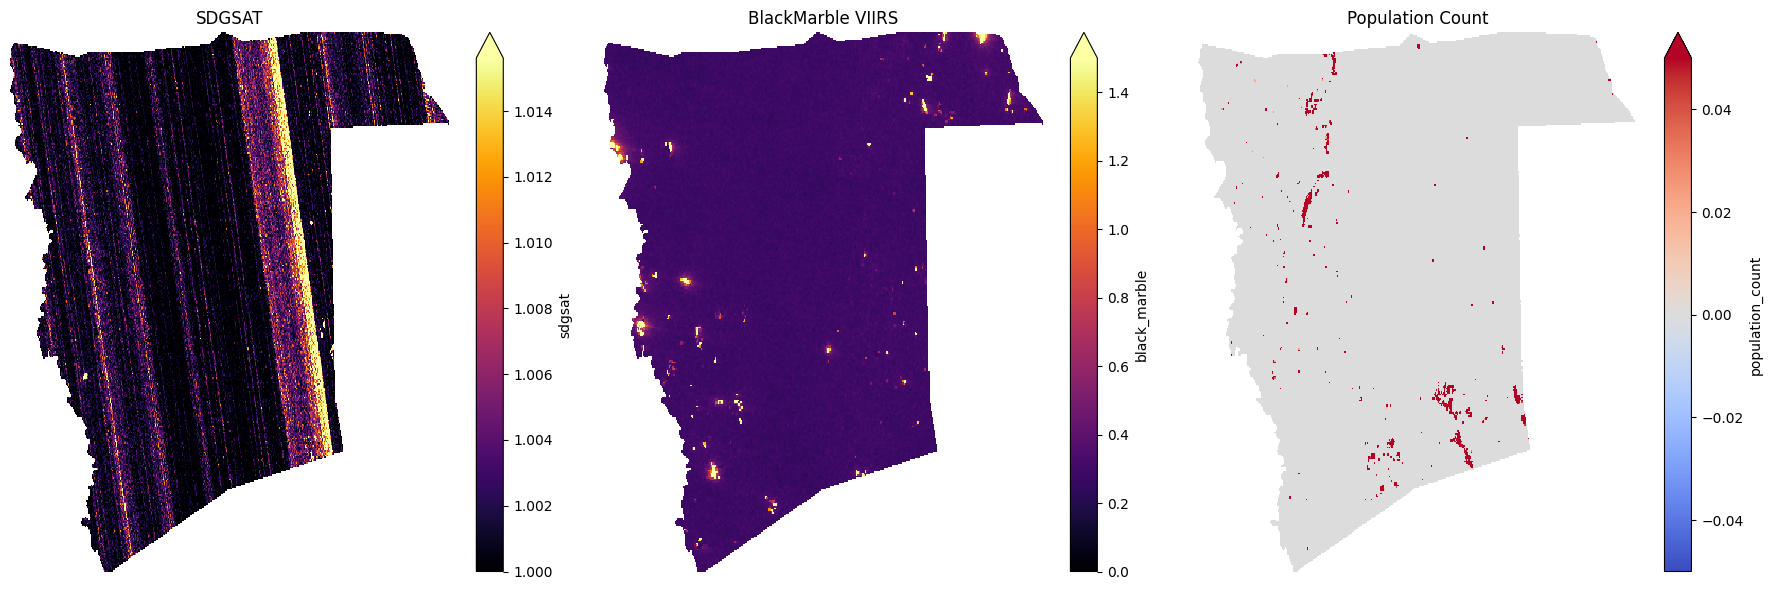

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

all_xds["sdgsat"].plot(ax=ax1, cmap="inferno", robust=True)
ax1.set_title("SDGSAT")
ax1.axis("off")

all_xds["black_marble"].plot(ax=ax2, cmap="inferno", robust=True, vmin=0, vmax=1.5)
ax2.set_title("BlackMarble VIIRS")
ax2.axis("off")

all_xds["population_count"].plot(ax=ax3, cmap="coolwarm", center=0, robust=True, vmin=0)
ax3.set_title("Population Count")
ax3.axis("off")

plt.tight_layout()
plt.show()

## Questions / Thoughts

- SDGSat DN starts from 1 (why?) + my logic with the conversion does not make sense
- Black Marble - day / month / year aggregate for analysis?
- How to make it more systematic: currently, I can only extract Admin 2 level (2015!) from [Global Administrative Unit Layers (GAUL)](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level2?_gl=1*1kxf6ad*_up*MQ..*_ga*MjAxNDkwODc4NC4xNzYwMjU0NDA5*_ga_SM8HXJ53K2*czE3NjAyNTc2MDIkbzIkZzAkdDE3NjAyNTc2MDIkajYwJGwwJGgw#table-schema)
